## Advanced Lane Line Finding


In [1]:
from importlib import reload
import utils; reload(utils)
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
cal_dir = "camera_cal"
test_imgs_dir = "test_images"
out_imgs_dir = "output_images"
out_videos_dir = "output_videos"

## Camera Calibration
Let's first get the paths of all our calibration images.

In [3]:
cal_img_paths = glob.glob(cal_dir + "/*.jpg")
print(len(cal_img_paths))

20


There are 20 images in the calibration image directory. Let's now take a look at the first chessboard image to see what it looks like. 

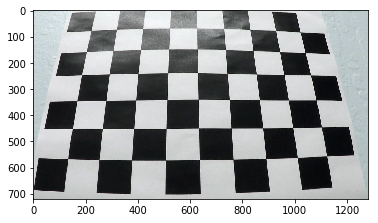

In [4]:
cal_img = cv2.imread(cal_img_paths[4])
plt.imshow(cal_img)

The Chessboard has 9x6 inner corners. We now use these parameters for the function `cv2.findChessboardCorners()`.

In [5]:
nx = 9
ny = 6

First of all, we feed the function a grayscaled image. 

In [6]:
gray = cv2.cvtColor(cal_img, cv2.COLOR_BGR2GRAY)

Now, we test the above functions with the first of the calibration images. 

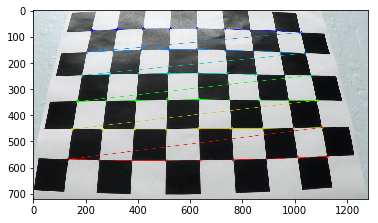

In [7]:
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
if ret == True:
    cv2.drawChessboardCorners(cal_img, (nx, ny), corners, ret)
    plt.imshow(cal_img)

The corner detection seems to be working, however not for all calibration images. Some images are too small, i.e. not all corners are visible. Next, we will use the found corners to undistort the camera. 

## Distortion Correction
With the above functions, we now correct for distortion. Therefore, we define image points and object points of the chessboard corners. 

### Find Image and Object Points

In [8]:
def get_object_image_points(img_path, nx, ny):
    
    # prepare object and image points
    obj_points = [] # 3D points in real world space
    img_points = [] # 2D points in image plane
    # Prepare object points, like (0, 0, 0), (1, 0, 0), (2, 0, 0),... , (8, 5, 0)
    obj_pts = np.zeros((6 * 9, 3), np.float32)
    obj_pts[:, :2] = np.mgrid[:9, :6].T.reshape(-1, 2)
    
    for img_file in img_path:
        # read in image
        img = cv2.imread(img_file)
        # convert image to grayscale
        gray = utils.to_grayscale(img)
    
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
        if ret == True:
            img_points.append(corners)
            obj_points.append(obj_pts)
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            
    return obj_points, img_points
        

In [9]:
obj_points, img_points = get_object_image_points(cal_img_paths, 9, 6)

In [10]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

### Undistorting test images


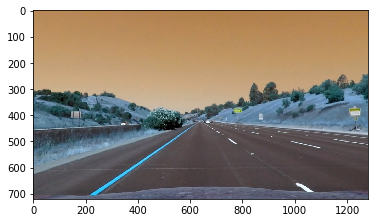

In [11]:
test_img_paths = glob.glob(test_imgs_dir + '/*.jpg')
for test_img_path in test_img_paths:
    test_img = cv2.imread(test_img_path)
    undist = cal_undistort(test_img, obj_points, img_points)
    plt.imshow(undist)

## Thresholding